Notebook pour l'entrainement, le test et l'optimisation de la partie "Reservoir" du PFE
Les différentes étapes de ce notebook de recherche:

  - **Entraînement du Modèle** : Nous montrerons comment entraîner l'ESN pour réaliser des tâches spécifiques de prédiction.
  - **Test et Validation** : Nous décrirons comment tester le modèle sur de nouvelles données pour évaluer sa performance et sa capacité à généraliser.
  - **Optimisation des Hyperparamètres** : Nous explorerons des techniques pour affiner les hyperparamètres du modèle afin d'améliorer ses performances selon 3 méthodes **didacticiel du notebook de référence**, **Hyperopt** et **Optuna**

# Prérequis

In [1]:
pip install reservoirpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00


Téléchargement du dataset sous forme d'une matrice de *taille nb_segments ***x*** 128* (nombre de notes midi)

In [2]:
! gdown --id 1TwSqcj3N1QxspHL6hFJDJwNSdw73Oi5-

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1TwSqcj3N1QxspHL6hFJDJwNSdw73Oi5-

but Gdown can't. Please check connections and permissions.


In [ ]:
import numpy as np

# Chargement des données d'entrée

X = np.load('all_label_concatenated.npy')
print(X.shape[0] )


FileNotFoundError: [Errno 2] No such file or directory: 'all_label_concatenated.npy'

In [ ]:
X_train = X[:-1, :]  # Toutes les lignes sauf la dernière, toutes les colonnes (notes)
Y_train = X[1:, :]   # Toutes les lignes à partir de la seconde, toutes les colonnes (notes)

# Modèle fonctionnel

Création et configuration du modèle réservoir type ESN (Echo state network)

## Configuration et Utilisation de l'Echo State Network pour la Transcription Audio en MIDI

Dans cette partie du projet, on configure et utilise un Echo State Network (ESN) pour transcrire des données audio en format MIDI. Les étapes clés de cette section sont les suivantes :

### Paramètres du Réservoir

On définit d'abord les paramètres du réservoir, qui sont cruciaux pour le bon fonctionnement de l'ESN :

- `units` : Le nombre d'unités ou de neurones dans le réservoir.
- `leak_rate` : Le taux de fuite, qui contrôle la vitesse à laquelle l'état du réservoir se met à jour.
- `spectral_radius` : Le rayon spectral de la matrice des poids du réservoir.
- `input_scaling` : Le facteur d'échelle pour les données d'entrée.
- `connectivity` : La densité de connectivité des poids dans le réservoir.

### Format des Données

On spécifie ensuite le format des données d'entrée et de sortie :

- `input_dim` : La dimension des données d'entrée, basée sur le nombre de note soit 128
- `output_dim` : la même dimension que input_dim, soit 128

### Création et Connexion du Réservoir et du Readout

Nous créons le réservoir et le readout (une couche de lecture) et les connectons :

- Le réservoir (`Reservoir`) est configuré avec les paramètres définis ci-dessus.
- Le readout (`Ridge`) est configuré pour faire correspondre les dimensions d'entrée et de sortie.

### Entraînement et Test de l'ESN

- Nous divisons les données en ensembles d'entraînement et de test.
- L'ESN est entraîné sur l'ensemble d'entraînement.
- Les performances de l'ESN sont évaluées sur l'ensemble de test, utilisant l'erreur quadratique moyenne (RMSE) comme métrique d'évaluation.



In [ ]:
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.model_selection import train_test_split

# Configuration du réservoir
units = 500  # Le nombre d'unités dans le réservoir, à ajuster en fonction de la complexité de la tâche
input_dim = X.shape[1]  # 128 pour le nombre de notes

#Paramètres optimaux trouvés grâce à la méthode optuna
reservoir = Reservoir(units=units,              #nombre de neurones
                      input_dim=input_dim,
                      sr=0.24341107666179235,  # Rayon spectral, ajusté empiriquement
                      lr=0.9815172099534998,  # Taux de fuite
                      input_scaling=0.717288409479667,  # Échelle des poids d'entrée
                      input_connectivity=0.57704968099127,  # Connectivité d'entrée
                      rc_connectivity=0.2964827343332025)  # Connectivité du réservoir

# Couche de sortie avec régression Ridge, également configurée pour 128 sorties
readout = Ridge(output_dim=input_dim, ridge=1.3023943314146852e-07)  # Utilise input_dim pour la cohérence

## méthode de feedback laissée en commentaire car dégrade les performances du modèle ##
#reservoir <<= readout

# Construction du modèle ESN
esn = reservoir >> readout

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


In [ ]:
#Configurations pour feedback, à laisser entre parenthèses

#reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None
#np.all(readout.Wout == 0.0)

False

In [ ]:
#Avec feedback
#esn.fit(X_train, Y_train,force_teachers=True, warmup=40) #sans feedback enlever force_teacher

## ENTRAINEMENT DU MODELE ##
esn.fit(X_train, Y_train)


#PARTIE NON TESTEE
"""
from sklearn.metrics import log_loss
import numpy as np

# Initialisation  d'un tableau pour stocker les erreurs BCE à chaque étape
bce_errors = []
n_epochs = 5

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Entraînement du modèle et calcule de la BCE pour chaque itération

for epoch in range(n_epochs):
    # Entraînement du modèle sur les données d'entraînement
    esn.fit(X_train, Y_train)
    Y_pred = esn.run(X_test)
    Y_pred_binarised = (Y_pred > 0.5).astype(int)

    bce_error = log_loss(Y_test, Y_pred_binarised)
    bce_errors.append(bce_error)

    print(f"BCE pour l'époque {epoch}: {bce_error}")
"""


Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 195it [00:00, 1945.51it/s]           
Running Model-0: 433it [00:00, 2198.03it/s]
Running Model-0: 667it [00:00, 2261.34it/s]
Running Model-0: 914it [00:00, 2342.04it/s]
Running Model-0: 1149it [00:00, 2291.75it/s]
Running Model-0: 1398it [00:00, 2355.31it/s]
Running Model-0: 1641it [00:00, 2377.42it/s]
Running Model-0: 1881it [00:00, 2382.38it/s]
Running Model-0: 2120it [00:00, 2307.56it/s]
Running Model-0: 2352it [00:01, 2297.22it/s]
Running Model-0: 2583it [00:01, 2295.43it/s]
Running Model-0: 2820it [00:01, 2316.66it/s]
Running Model-0: 3054it [00:01, 2322.44it/s]
Running Model-0: 3293it [00:01, 2339.45it/s]
Running Model-0: 3528it [00:01, 2308.67it/s]
Running Model-0: 3767it [00:01, 2330.58it/s]
Running Model-0: 4001it [00:01, 2318.92it/s]
Running Model-0: 4245it [00:01, 2352.74it/s]
Running Model-0: 4485it [00:01, 2366.77it/s]
Running Model-0: 4722it [00:02, 2326.63it/s]
Running Model-0: 4955it [00:02, 2316.7

Fitting node Ridge-0...


'Model-0': Model('Reservoir-0', 'Ridge-0')

In [ ]:
#Verification que tout s'est bien déroulé
print(reservoir.is_initialized, readout.is_initialized, readout.fitted)

#Avec feedback
#print("Feedback received (reservoir):", reservoir.feedback())
#print("State sent: (readout):", readout.state())


True True True


RuntimeError: Node 'Reservoir-10': Reservoir(lr=0.9815172099534998, sr=0.9434110766617924, input_scaling=0.717288409479667, bias_scaling=1.0, fb_scaling=1.0, rc_connectivity=0.2964827343332025, input_connectivity=0.57704968099127, fb_connectivity=0.1, noise_in=0.0, noise_rc=0.0, noise_out=0.0, noise_type=normal, activation=<function tanh at 0x7ca23bb55d80>, fb_activation=<function identity at 0x7ca23bb56dd0>, units=400, noise_generator=functools.partial(<function noise at 0x7ca1cb36f880>, rng=Generator(PCG64) at 0x7CA1CB2FD2A0), in=128, out=400) is not connected to any feedback Node or Model.

KeyboardInterrupt: 

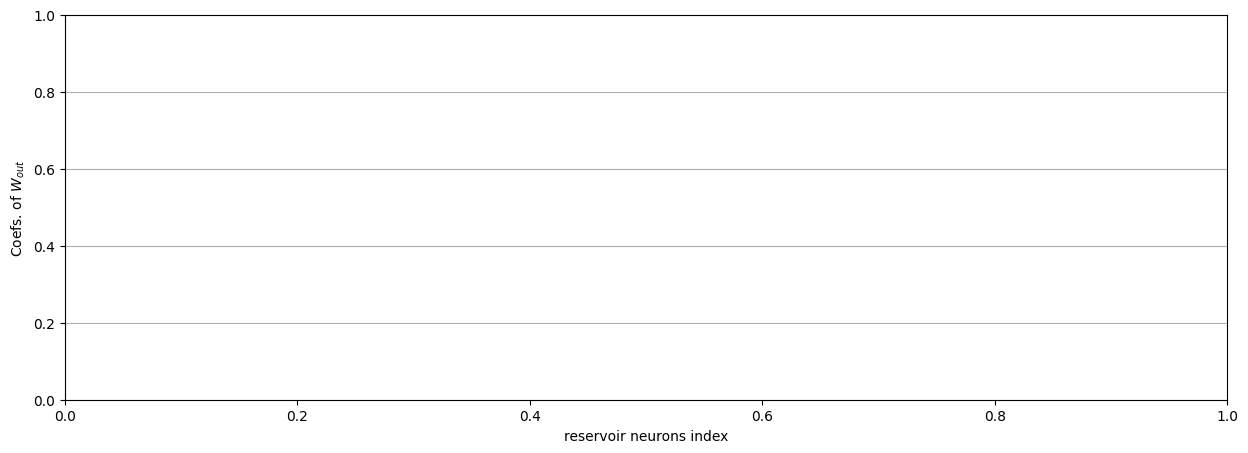

In [ ]:
#OPTIONNEL : AFFICHAGE DE LA REPARTION DE L'ENSEMBLE DES NEURONNES ACTIFS DU MODELE

import matplotlib
import matplotlib.pyplot as plt
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

plot_readout(readout)

In [ ]:
#Sans feedback
Y_pred = esn.run(X_test) #sans feedback enlever forced_feedbacks et shift

## LANCEMENT ET TEST DU MODELE

#Avec feedback
#Y_pred = esn.run(X_test,forced_feedbacks=Y_train, shift_fb=True) #sans feedback enlever forced_feedbacks et shift


Running Model-0: 242808it [02:38, 1531.54it/s]


Calcul des métriques:
- Précision
- Recall
- F1
- RMSE

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error

# Seuil pour binariser les prédictions
seuil = 0.5
Y_pred_binarise = (Y_pred > seuil).astype(int)

# Calcule des métriques après binarisation
precision = precision_score(Y_test, Y_pred_binarise, average='macro')
recall = recall_score(Y_test, Y_pred_binarise, average='macro')
f1 = f1_score(Y_test, Y_pred_binarise, average='macro')
rmse = mean_squared_error(Y_test, predictions, squared=False)

print(f"Précision: {precision}")
print(f"Rappel: {recall}")
print(f"F1-Score: {f1}")
print("RMSE:", rmse)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Précision: 0.46596237648148225
Rappel: 0.4434319151539723
F1-Score: 0.44925286328641695


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


#######################################################################################
AFFICHAGE COMPARAISON VERITABLE ET PREDICTION POUR UN SEGMENT DONNÉ

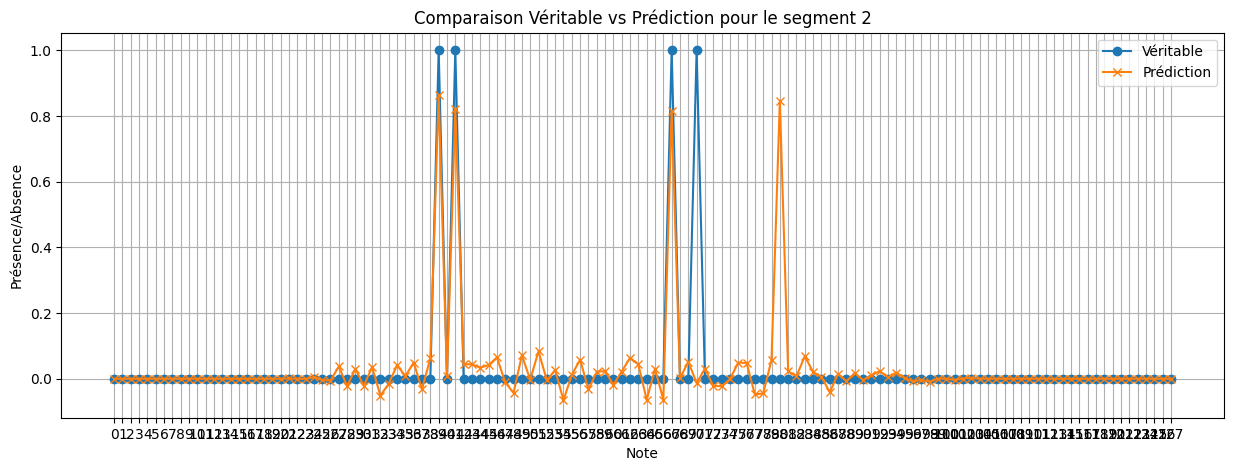

In [ ]:
import matplotlib.pyplot as plt

# Exemple de visualisation pour un seul segment
segment_index = 2  # Choisir un segment pour la visualisation

plt.figure(figsize=(15, 5))
plt.plot(Y_test[segment_index], label="Véritable", marker='o')
plt.plot(Y_pred[segment_index], label="Prédiction", marker='x')
plt.title(f"Comparaison Véritable vs Prédiction pour le segment {segment_index}")
plt.xlabel("Note")
plt.ylabel("Présence/Absence")
plt.xticks(range(len(Y_test[segment_index])))
plt.legend()
plt.grid(True)
plt.savefig('comparaison_segment.png', dpi=300)

plt.show()


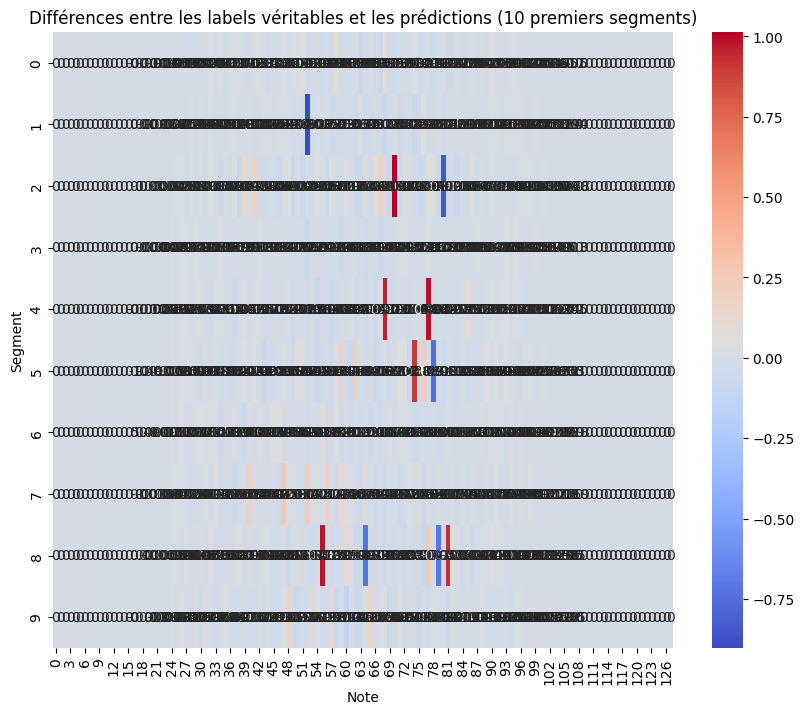

In [ ]:
import seaborn as sns

# Utilisation de seaborn pour une heatmap d'analyse
plt.figure(figsize=(10, 8))
sns.heatmap(Y_test[:10] - Y_pred[:10], cmap="coolwarm", annot=True)
plt.title("Différences entre les labels véritables et les prédictions (10 premiers segments)")
plt.xlabel("Note")
plt.ylabel("Segment")
plt.show()


INTERPRETATION:

En jaune/blanc les predictions correctes, en rouge les labels veritable non detectée, en bleu les predictions erronées

Ajout d'une nouvelle métrique pour le calcul de la loss (perte)

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy

# Définition de la fonction de perte
criterion = BinaryCrossentropy()

# Calcul de la perte
loss = criterion(Y_test, Y_pred).numpy()
print(f"Binary Cross-Entropy Loss: {loss}")

Binary Cross-Entropy Loss: 0.04923497157253179


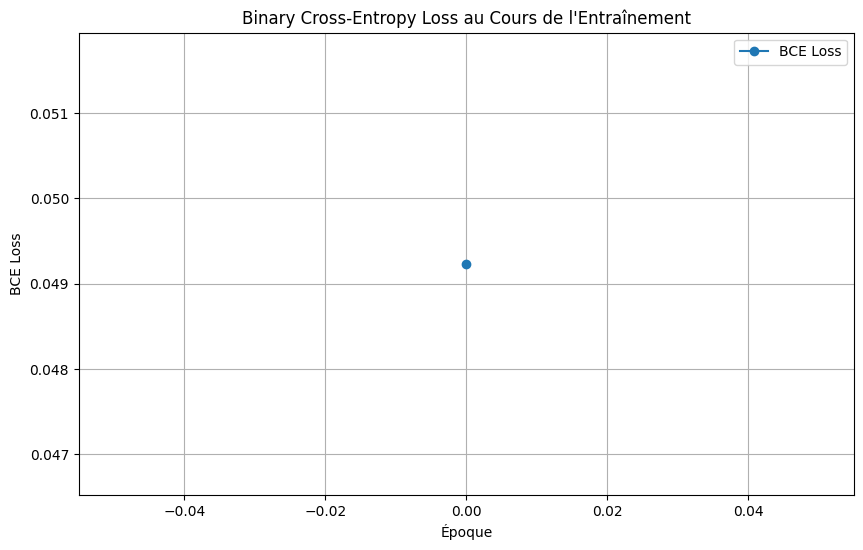

In [ ]:
#PARTIE EN LIEN AVEC LA VERSION 2 DE L'ENTRAINEMENT DU MODELE

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bce_errors, label='BCE Loss', marker='o')
plt.title("Binary Cross-Entropy Loss au Cours de l'Entraînement")
plt.xlabel("Époque")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def nrmse(y_true, y_pred):
    rmse_val = rmse(y_true, y_pred)
    return rmse_val / (y_true.max() - y_true.min())

# Calculer RMSE
rmse_val = rmse(Y_test, Y_pred)
print(f"RMSE: {rmse_val}")

# Calculer NRMSE
nrmse_val = nrmse(Y_test, Y_pred)
print(f"NRMSE: {nrmse_val}")

RMSE: 0.09508222313937083
NRMSE: 0.09508222313937083


SAUVEGARDE DU MODELE

In [ ]:
import pickle

# Supposons que 'esn' est votre modèle ESN entraîné
with open('esn_model.pkl', 'wb') as file:
    pickle.dump(esn, file)


# Test du modèle

In [ ]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=f55aa5923db10f5a79b04551a914486e9f677e97422a2194f725b2657680f170
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
##VERSION 1 DU TEST DU MODELE

import pretty_midi
def predict_and_transcribe_to_midi(model, X_new, output_midi_filename='predicted_music.mid', time_step=0.1):
    """
    Utilise un modèle ESN entraîné pour prédire les états des notes à partir de nouvelles données d'entrée
    et transcrit ces prédictions en un fichier MIDI.

    :param model: Le modèle ESN entraîné.
    :param X_new: Nouvelles données d'entrée pour lesquelles effectuer des prédictions.
    :param output_midi_filename: Nom du fichier MIDI à générer.
    :param time_step: Intervalle de temps entre chaque état de note prédit, en secondes.
    """

    # Effectue la prédiction avec le modèle
    Y_pred = model.run(X_new)

    # Binarise les prédictions si nécessaire
    Y_pred_binarised = (Y_pred > 0.5).astype(int)
    # Créer un nouvel objet PrettyMIDI pour notre musique
    midi_file = pretty_midi.PrettyMIDI()
    # Créer un instrument pour ajouter les notes
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

    sample_rate = 0.1

    for note_number in range(Y_pred_binarise.shape[1]):  # Pour chaque note
        start_time = None
        for timestep, is_note_played in enumerate(Y_pred_binarise[:, note_number]):
            if is_note_played and start_time is None:  # Début de la note
                start_time = timestep * sample_rate
            elif not is_note_played and start_time is not None:  # Fin de la note
                end_time = timestep * sample_rate
                # Créer et ajoute la note à l'instrument
                note = pretty_midi.Note(velocity=100, pitch=note_number, start=start_time, end=end_time)
                instrument.notes.append(note)
                start_time = None

    # Ajoute l'instrument au fichier MIDI et sauvegarder
    midi_file.instruments.append(instrument)
    midi_file.write('output.mid')





In [ ]:
##VERSION 2 ET TEST DU MODELE
import pretty_midi
import numpy as np

def predict_and_transcribe_to_midi(model, X_new, output_midi_filename='predicted_music.mid', time_step=0.1):
    """
    Utilise un modèle ESN entraîné pour prédire les états des notes à partir de nouvelles données d'entrée
    et transcrit ces prédictions en un fichier MIDI.

    :param model: Le modèle ESN entraîné.
    :param X_new: Nouvelles données d'entrée pour lesquelles effectuer des prédictions.
    :param output_midi_filename: Nom du fichier MIDI à générer.
    :param time_step: Intervalle de temps entre chaque état de note prédit, en secondes.
    """

    # Effectue la prédiction avec le modèle
    Y_pred = model.run(X_new)

    # Binarise les prédictions si nécessaire
    Y_pred_binarised = (Y_pred > 0.5).astype(int)

    # Créer un nouvel objet PrettyMIDI
    midi_file = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)

    # Génére et ajoute les notes au fichier MIDI basé sur les prédictions binarisées
    for note_number in range(Y_pred_binarised.shape[1]):  # Pour chaque note
        for timestep, is_note_played in enumerate(Y_pred_binarised[:, note_number]):
            if is_note_played:  # Si la note est jouée
                # Créer une note
                note = pretty_midi.Note(
                    velocity=100,  # La vélocité de la note
                    pitch=note_number + 21,  # Peut-etre ajouter 21 pour que le numéro de note corresponde à la gamme MIDI
                    start=timestep * time_step,  # Début de la note
                    end=(timestep + 1) * time_step  # Fin de la note
                )
                # Ajouter la note à l'instrument
                piano.notes.append(note)

    # Ajouter l'instrument au fichier MIDI et sauvegarder le fichier
    midi_file.instruments.append(piano)
    midi_file.write(output_midi_filename)

    print(f'Fichier MIDI généré : {output_midi_filename}')


In [ ]:
print("end of file !")

fin du fichier !


# recherche optimale des hyper-para avec methode du notebook reservoir computing

In [ ]:
#NE FONCTIONNE PAS, PAS ASSEZ DE RESSOURCES (RAM)
from hyperopt import STATUS_OK
from reservoirpy.nodes import Reservoir, Ridge
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split

def objective(X, config, *, units, input_dim, input_scaling, input_connectivity, rc_connectivity, sr, lr, ridge, seed):

    X_train = X[:-1, :]  # Toutes les lignes sauf la dernière, toutes les colonnes (notes)
    Y_train = X[1:, :]   # Toutes les lignes à partir de la seconde, toutes les colonnes (notes)
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

    instances = config["instances_per_trial"]

    variable_seed = seed
    losses = []; r2s = [];
    for n in range (instances) :

      # Configuration du modèle ESN avec les paramètres
      reservoir = Reservoir(units=int(units), input_dim=128, sr=sr, lr=lr,
                            input_scaling=input_scaling, input_connectivity=input_connectivity,
                            rc_connectivity=rc_connectivity, seed=variable_seed)
      readout = Ridge(output_dim=128, ridge=ridge)
      model = reservoir >> readout
      print("Reservoir created correctly")

      #X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)


      predictions = model.fit(X_train, Y_train) \
                           .run(X_test)

      loss = nrmse(Y_test, predictions, norm_value=np.ptp(X_train))
      r2 = rsquare(Y_test, predictions)
      variable_seed += 1

      losses.append(loss)
      r2s.append(r2)

    # Retourne un dictionnaire de metriques. La 'loss' key est obligatoire avec hyperopt
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}



In [ ]:
from hyperopt import hp
from reservoirpy.observables import nrmse, rsquare

hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # nom de l'experience
    "hp_max_evals": 1,             # le nombre de sets d'hyperparametres à tester
    "hp_method": "random",           # la méthode de choix des hyperparametres
    "seed": 42,                      # graine aléatoire
    "instances_per_trial": 3,        # combien d'ESN aléatoires seront essayés avec chaque set de parametres
    "hp_space" : {
        "units": ["uniform",100,500],
        "input_dim" : [128],
        "sr": ["uniform", 0.1, 1.5],
        "lr": ["uniform", 0.1, 1],
        "input_scaling": ["uniform",0.1,0.5],
        "input_connectivity": ["uniform", 0.05, 0.9],
        "rc_connectivity": ["uniform", 0.1, 0.9],
        "ridge": ["choice",1e-7],
        "seed" : ["choice",1234]
          }
        }

import json

with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)




In [ ]:
from reservoirpy.hyper import research

best = research(objective,X, f"{hyperopt_config['exp']}.config.json", ".")


jusque la tout va bien
  0%|          | 0/1 [00:05<?, ?trial/s, best loss=?]

Streaming output truncated to the last 5000 lines.

Running Model-0: 503916it [04:28, 1947.30it/s]

Running Model-0: 504124it [04:28, 1985.45it/s]

Running Model-0: 504324it [04:28, 1989.38it/s]

Running Model-0: 504524it [04:28, 1972.55it/s]

Running Model-0: 504726it [04:28, 1984.59it/s]

Running Model-0: 504929it [04:28, 1996.08it/s]

Running Model-0: 505129it [04:28, 1967.57it/s]

Running Model-0: 505326it [04:28, 1962.30it/s]

Running Model-0: 505523it [04:29, 1940.97it/s]

Running Model-0: 505718it [04:29, 1911.82it/s]

Running Model-0: 505910it [04:29, 1904.80it/s]

Running Model-0: 506102it [04:29, 1907.95it/s]

Running Model-0: 506293it [04:29, 1890.76it/s]

Running Model-0: 506486it [04:29, 1902.14it/s]

Running Model-0: 506681it [04:29, 1914.62it/s]

Running Model-0: 506876it [04:29, 1924.90it/s]

Running Model-0: 507069it [04:29, 1906.47it/s]

Running Model-0: 507260it [04:29, 1783.92it/s]

Running Model-0: 507440it [04:30, 1643.23it/s]

Running Model-0: 507608it [04:30, 16

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr"), metric="r2")

ValueError: zero-size array to reduction operation minimum which has no identity

# Recherche optimale des hyper-parametres avec Hyperopt Version 2

In [ ]:
from hyperopt import hp

space = {
    'units': hp.uniform('units',100,1000),
    'sr': hp.uniform('sr', 0.9, 1.5),
    'lr': hp.uniform('lr', 0.1, 0.5),
    'input_scaling': hp.uniform('input_scaling', 0.1, 1.0),
    'input_connectivity': hp.uniform('input_connectivity', 0.05, 0.2),
    'rc_connectivity': hp.uniform('rc_connectivity', 0.1, 0.5),
    'ridge': hp.loguniform('ridge', np.log(1e-8), np.log(1e-5))
}


In [ ]:
from hyperopt import STATUS_OK
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import precision_score, recall_score, f1_score
from reservoirpy.observables import nrmse, rsquare
def objective(params):
    units = params['units']
    sr = params['sr']
    lr = params['lr']
    input_scaling = params['input_scaling']
    input_connectivity = params['input_connectivity']
    rc_connectivity = params['rc_connectivity']
    ridge = params['ridge']

    # Configuration du modèle ESN avec les paramètres
    reservoir = Reservoir(units=int(units), input_dim=128, sr=sr, lr=lr,
                          input_scaling=input_scaling, input_connectivity=input_connectivity,
                          rc_connectivity=rc_connectivity)
    readout = Ridge(output_dim=128, ridge=ridge)
    esn = reservoir >> readout

    esn.fit(X_train, Y_train)
    Y_pred = esn.run(X_test)
    seuil = 0.5
    Y_pred_binarise = (Y_pred > seuil).astype(int)


    precision = precision_score(Y_test, Y_pred_binarise, average='macro')
    recall = recall_score(Y_test, Y_pred_binarise, average='macro')
    f1 = f1_score(Y_test, Y_pred_binarise, average='macro')

    print(f"Précision: {precision}")
    print(f"Rappel: {recall}")
    print(f"F1-Score: {f1}")


    # Définition de la fonction de perte
    criterion = BinaryCrossentropy()

    # Calcul de la perte
    loss = criterion(Y_test, Y_pred)
    print(f"Binary Cross-Entropy Loss: {loss}")
    rsq = rsquare(Y_test, Y_pred)
    val_nrmse = nrmse(Y_test, Y_pred)
    return {'rsquare':rsq, 'nrmse':val_nrmse, 'loss': loss, 'status': STATUS_OK}


In [ ]:
from hyperopt import fmin, tpe, Trials
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.model_selection import train_test_split
from reservoirpy.observables import nrmse, rsquare
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,  # Nombre d'itérations d'optimisation
            trials=trials)

print(best)


  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

Streaming output truncated to the last 5000 lines.

Running Model-0: 747490it [14:20, 931.06it/s]

Running Model-0: 747584it [14:20, 918.62it/s]

Running Model-0: 747676it [14:20, 913.68it/s]

Running Model-0: 747768it [14:20, 913.14it/s]

Running Model-0: 747860it [14:21, 908.21it/s]

Running Model-0: 747958it [14:21, 927.79it/s]

Running Model-0: 748053it [14:21, 931.51it/s]

Running Model-0: 748147it [14:21, 928.64it/s]

Running Model-0: 748242it [14:21, 932.09it/s]

Running Model-0: 748337it [14:21, 937.30it/s]

Running Model-0: 748431it [14:21, 927.34it/s]

Running Model-0: 748524it [14:21, 907.18it/s]

Running Model-0: 748618it [14:21, 916.11it/s]

Running Model-0: 748710it [14:21, 915.19it/s]

Running Model-0: 748802it [14:22, 896.47it/s]

Running Model-0: 748892it [14:22, 881.82it/s]

Running Model-0: 748985it [14:22, 894.59it/s]

Running Model-0: 749075it [14:22, 891.58it/s]

Running Model-0: 749169it [14:22, 903.46it/s]

Running Model-0: 749262it [14:22, 911.24it/s]

Running 

In [ ]:
lr_values = [x['lr'] for x in trials.vals['lr']]
sr_values = [x['sr'] for x in trials.vals['sr']]
losses = [x['loss'] for x in trials.results]


NameError: name 'trials' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(lr_values, sr_values, c=losses, cmap='viridis')
plt.colorbar(label='Perte')
plt.xlabel('Taux de fuite (lr)')
plt.ylabel('Rayon spectral (sr)')
plt.title('Impact de lr et sr sur la Perte')
plt.show()


#Online Learning

In [ ]:
#NON FONCTIONNEL, PAS ASSEZ DE RAM ET DE PUISSANCE DE CALCUL

from reservoirpy.nodes import FORCE

reservoir = Reservoir(units=500,
                      input_dim=input_dim,
                      sr=0.5,  # Rayon spectral, ajusté empiriquement
                      lr=0.9,  # Taux de fuite
                      input_scaling=0.5,  # Échelle des poids d'entrée
                      input_connectivity=0.1,  # Connectivité d'entrée
                      rc_connectivity=0.5)  # Connectivité du réservoir

# Couche de sortie avec régression Ridge, également configurée pour 128 sorties

eadout = Ridge(output_dim=input_dim, ridge=1e-7)  # Utilise input_dim pour la cohérence


esn_online = reservoir >> readout


In [ ]:
esn_online.train(X_train, Y_train)
pred_online = esn_online.run(X_test)  # Wout est maintenant figée


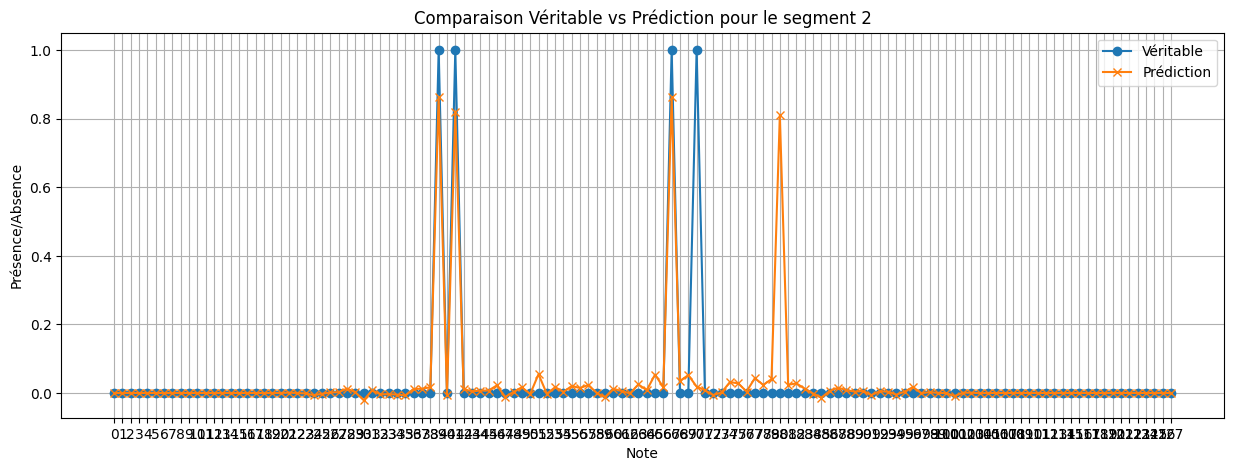

In [ ]:
import matplotlib.pyplot as plt

# Exemple de visualisation pour un seul segment
segment_index = 2  # Choisir un segment pour la visualisation

plt.figure(figsize=(15, 5))
plt.plot(Y_test[segment_index], label="Véritable", marker='o')
plt.plot(pred_online[segment_index], label="Prédiction", marker='x')
plt.title(f"Comparaison Véritable vs Prédiction pour le segment {segment_index}")
plt.xlabel("Note")
plt.ylabel("Présence/Absence")
plt.xticks(range(len(Y_test[segment_index])))
plt.legend()
plt.grid(True)
plt.savefig('comparaison_segment.png', dpi=300)

plt.show()


# Optimisation Optuna version

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.1 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

def objective(trial):
    # Suggestion d'hyperparamètres
    units = trial.suggest_int("units", 100, 1000)
    sr = trial.suggest_uniform("sr", 0.1, 2)
    lr = trial.suggest_uniform("lr", 0.1, 1)
    input_scaling = trial.suggest_uniform("input_scaling", 0.1, 1)
    input_connectivity = trial.suggest_uniform("input_connectivity", 0.1, 1)
    rc_connectivity = trial.suggest_uniform("rc_connectivity", 0.1, 1)
    ridge = trial.suggest_loguniform("ridge", 1e-8, 1e-2)

    # Configuration du réservoir et de la couche de lecture avec les hyperparamètres suggérés
    reservoir = Reservoir(units=units, input_dim=input_dim, sr=sr, lr=lr,
                          input_scaling=input_scaling, input_connectivity=input_connectivity,
                          rc_connectivity=rc_connectivity)
    readout = Ridge(output_dim=input_dim, ridge=ridge)

    esn = reservoir >> readout



    # Entraînement et évaluation du modèle
    esn.fit(X_train, Y_train)
    Y_pred = esn.run(X_test)

    #metriques
    loss = log_loss(Y_test, Y_pred)

    return loss


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)
print("Meilleurs hyperparamètres : ", study.best_params)


[I 2024-02-12 15:06:07,329] A new study created in memory with name: no-name-91336764-870a-4688-8416-ab8040fed41a
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:11: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

Fitting node Ridge-43...


Running Model-43: 2240it [00:01, 1165.86it/s]
[I 2024-02-12 15:06:14,649] Trial 0 finished with value: 18.4059710617188 and parameters: {'units': 640, 'sr': 0.521001478779949, 'lr': 0.17322930942163944, 'input_scaling': 0.8230232645211956, 'input_connectivity': 0.5231966958963291, 'rc_connectivity': 0.19137930498249328, 'ridge': 1.0040497795822906e-07}. Best is trial 0 with value: 18.4059710617188.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See http

Fitting node Ridge-44...


Running Model-44: 2240it [00:03, 743.53it/s]
[I 2024-02-12 15:06:25,475] Trial 1 finished with value: 18.035427272426297 and parameters: {'units': 558, 'sr': 0.2977231369975479, 'lr': 0.17797624793998718, 'input_scaling': 0.6265254364006955, 'input_connectivity': 0.1598944230765646, 'rc_connectivity': 0.965723294551857, 'ridge': 0.00022032181149170214}. Best is trial 1 with value: 18.035427272426297.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See ht

Fitting node Ridge-45...


Running Model-45: 2240it [00:01, 1561.95it/s]
[I 2024-02-12 15:06:32,182] Trial 2 finished with value: 16.689463326114943 and parameters: {'units': 419, 'sr': 1.826345369603047, 'lr': 0.9897907327064988, 'input_scaling': 0.32161391656307914, 'input_connectivity': 0.19646584094759353, 'rc_connectivity': 0.8838353969840085, 'ridge': 1.5514097684728305e-05}. Best is trial 2 with value: 16.689463326114943.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

Fitting node Ridge-46...


Running Model-46: 2240it [00:01, 1543.50it/s]
[I 2024-02-12 15:06:37,080] Trial 3 finished with value: 16.76283939110622 and parameters: {'units': 264, 'sr': 1.2887977411307807, 'lr': 0.4601552743845524, 'input_scaling': 0.9472833527741638, 'input_connectivity': 0.8887091274528502, 'rc_connectivity': 0.7104656884720039, 'ridge': 9.227387765357349e-07}. Best is trial 2 with value: 16.689463326114943.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See htt

Fitting node Ridge-47...


Running Model-47: 2240it [00:01, 1992.51it/s]
[I 2024-02-12 15:06:42,872] Trial 4 finished with value: 15.969016765675699 and parameters: {'units': 388, 'sr': 0.9855209907829972, 'lr': 0.6466464702161413, 'input_scaling': 0.7634067884451011, 'input_connectivity': 0.6940797461646889, 'rc_connectivity': 0.37437913228074915, 'ridge': 2.471795639346763e-07}. Best is trial 4 with value: 15.969016765675699.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

Fitting node Ridge-48...


Running Model-48: 2240it [00:00, 2421.21it/s]
[I 2024-02-12 15:06:46,688] Trial 5 finished with value: 17.243638015224004 and parameters: {'units': 213, 'sr': 1.3444772591243532, 'lr': 0.33992411321707167, 'input_scaling': 0.538423039791634, 'input_connectivity': 0.8599279988445651, 'rc_connectivity': 0.6086125774676342, 'ridge': 0.0003818137367586632}. Best is trial 4 with value: 15.969016765675699.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See ht

Fitting node Ridge-49...


Running Model-49: 2240it [00:01, 1127.79it/s]
[I 2024-02-12 15:06:56,273] Trial 6 finished with value: 15.211186471162042 and parameters: {'units': 936, 'sr': 0.6059518761868832, 'lr': 0.6870357688709839, 'input_scaling': 0.6648039348976693, 'input_connectivity': 0.4664806489163882, 'rc_connectivity': 0.21043384659852732, 'ridge': 0.00011793544533092786}. Best is trial 6 with value: 15.211186471162042.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

Fitting node Ridge-50...


Running Model-50: 2240it [00:01, 1146.51it/s]
[I 2024-02-12 15:07:05,736] Trial 7 finished with value: 16.350199770429096 and parameters: {'units': 825, 'sr': 1.7861926107134984, 'lr': 0.4032746845739741, 'input_scaling': 0.8808346096819472, 'input_connectivity': 0.8036568422513002, 'rc_connectivity': 0.2685515346678247, 'ridge': 0.00014185049800115353}. Best is trial 6 with value: 15.211186471162042.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

Fitting node Ridge-51...


Running Model-51: 2240it [00:00, 2305.78it/s]
[I 2024-02-12 15:07:09,767] Trial 8 finished with value: 15.314213408028971 and parameters: {'units': 253, 'sr': 1.1488084198246982, 'lr': 0.38188839304529376, 'input_scaling': 0.1292245591133771, 'input_connectivity': 0.1770378306722299, 'rc_connectivity': 0.7619297035524962, 'ridge': 0.00010902016652801575}. Best is trial 6 with value: 15.211186471162042.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

Fitting node Ridge-52...


Running Model-52: 2240it [00:01, 1264.47it/s]
[I 2024-02-12 15:07:16,630] Trial 9 finished with value: 15.785910234705963 and parameters: {'units': 808, 'sr': 1.3817570646090873, 'lr': 0.40058163768772215, 'input_scaling': 0.5594531916128771, 'input_connectivity': 0.12363836260261482, 'rc_connectivity': 0.13796149246116654, 'ridge': 1.3583596318010225e-06}. Best is trial 6 with value: 15.211186471162042.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

Fitting node Ridge-53...


Running Model-53: 2240it [00:02, 762.36it/s]
[I 2024-02-12 15:07:30,877] Trial 10 finished with value: 15.107973817032592 and parameters: {'units': 995, 'sr': 0.7083196180861415, 'lr': 0.7552118318213915, 'input_scaling': 0.38003980488390016, 'input_connectivity': 0.4368499527678578, 'rc_connectivity': 0.41491984621735023, 'ridge': 0.0046586808980116825}. Best is trial 10 with value: 15.107973817032592.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

Fitting node Ridge-54...


Running Model-54: 2240it [00:02, 896.76it/s]
[I 2024-02-12 15:07:44,481] Trial 11 finished with value: 15.339584724518415 and parameters: {'units': 964, 'sr': 0.7004061379783781, 'lr': 0.6823134709981024, 'input_scaling': 0.3612811976921718, 'input_connectivity': 0.4269430635724547, 'rc_connectivity': 0.3668792254508738, 'ridge': 0.009938005449547}. Best is trial 10 with value: 15.107973817032592.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

Fitting node Ridge-55...


Running Model-55: 2240it [00:03, 744.54it/s]
[I 2024-02-12 15:07:59,414] Trial 12 finished with value: 14.413367001671684 and parameters: {'units': 975, 'sr': 0.13930487532086522, 'lr': 0.8274310129672782, 'input_scaling': 0.4260079997107742, 'input_connectivity': 0.36545353215770876, 'rc_connectivity': 0.4903036168480972, 'ridge': 0.009435973908881798}. Best is trial 12 with value: 14.413367001671684.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

Fitting node Ridge-56...


Running Model-56: 2240it [00:02, 996.78it/s]
[I 2024-02-12 15:08:10,167] Trial 13 finished with value: 14.122578118198843 and parameters: {'units': 761, 'sr': 0.1044743275044574, 'lr': 0.898091408453742, 'input_scaling': 0.38556657177210285, 'input_connectivity': 0.3417626549511542, 'rc_connectivity': 0.48922332101789895, 'ridge': 0.006271693790699221}. Best is trial 13 with value: 14.122578118198843.
<ipython-input-126-4f9c213e444e>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-126-4f9c213e444e>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

Fitting node Ridge-57...


Running Model-57: 2240it [00:02, 1008.56it/s]
[I 2024-02-12 15:08:21,135] Trial 14 finished with value: 14.203293868994372 and parameters: {'units': 736, 'sr': 0.253515821086732, 'lr': 0.9217053361237127, 'input_scaling': 0.19158080465687724, 'input_connectivity': 0.3165895878738747, 'rc_connectivity': 0.5165747531461644, 'ridge': 0.0019380713624047882}. Best is trial 13 with value: 14.122578118198843.


Meilleurs hyperparamètres :  {'units': 761, 'sr': 0.1044743275044574, 'lr': 0.898091408453742, 'input_scaling': 0.38556657177210285, 'input_connectivity': 0.3417626549511542, 'rc_connectivity': 0.48922332101789895, 'ridge': 0.006271693790699221}


In [ ]:
optuna.visualization.plot_optimization_history(study)
#optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['units', 'sr', 'lr', 'input_scaling'])


In [ ]:
optuna.visualization.plot_slice(study)


In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
optuna.visualization.plot_param_importances(study, evaluator=optuna.importance.FanovaImportanceEvaluator())



# Test parametres optimaux

In [ ]:
from reservoirpy.nodes import Reservoir, Ridge

# Configuration du réservoir
units = 761  # Le nombre d'unités dans le réservoir, à ajuster en fonction de la complexité de la tâche
input_dim = X.shape[1]  # 128 pour vos données

reservoir = Reservoir(units=units,
                      input_dim=input_dim,
                      sr=0.1044743275044574,  # Rayon spectral, ajusté empiriquement
                      lr=0.898091408453742,  # Taux de fuite
                      input_scaling=0.38556657177210285,  # Échelle des poids d'entrée
                      input_connectivity=0.3417626549511542,  # Connectivité d'entrée
                      rc_connectivity=0.48922332101789895)  # Connectivité du réservoir

# Couche de sortie avec régression Ridge, également configurée pour 128 sorties
readout = Ridge(output_dim=input_dim, ridge=0.006271693790699221)  # Utilise input_dim pour la cohérence

#feedback
#reservoir <<= readout
# Construction du modèle ESN
esn = reservoir >> readout

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


In [ ]:
esn.fit(X_train, Y_train) #sans feedback enlever force_teacher

Running Model-58:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-58: 103it [00:00, 1027.80it/s]           
Running Model-58: 236it [00:00, 1204.02it/s]
Running Model-58: 361it [00:00, 1224.84it/s]
Running Model-58: 484it [00:00, 1200.21it/s]
Running Model-58: 608it [00:00, 1214.10it/s]
Running Model-58: 739it [00:00, 1246.08it/s]
Running Model-58: 871it [00:00, 1268.05it/s]
Running Model-58: 1002it [00:00, 1279.20it/s]
Running Model-58: 1130it [00:00, 1254.38it/s]
Running Model-58: 1256it [00:01, 1242.58it/s]
Running Model-58: 1381it [00:01, 1229.30it/s]
Running Model-58: 1505it [00:01, 1232.34it/s]
Running Model-58: 1629it [00:01, 1229.54it/s]
Running Model-58: 1754it [00:01, 1234.96it/s]
Running Model-58: 1887it [00:01, 1261.00it/s]
Running Model-58: 2020it [00:01, 1278.87it/s]
Running Model-58: 2154it [00:01, 1296.46it/s]
Running Model-58: 2284it [00:01, 1294.75it/s]
Running Model-58: 2414it [00:01, 1269.48it/s]
Running Model-58: 2545it [00:02, 1279.91it/s]
Running Model-58: 26

Fitting node Ridge-58...


'Model-58': Model('Reservoir-58', 'Ridge-58')

In [ ]:
print(reservoir.is_initialized, readout.is_initialized, readout.fitted)
#print("Feedback received (reservoir):", reservoir.feedback())
#print("State sent: (readout):", readout.state())


True True True


In [ ]:
Y_pred = esn.run(X_test) #sans feedback enlever forced_feedbacks et shift


Running Model-58: 1792it [00:01, 997.35it/s] 


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Seuil pour binariser les prédictions
seuil = 0.5
Y_pred_binarise = (Y_pred > seuil).astype(int)

# Calculer les métriques après binarisation
precision = precision_score(Y_test, Y_pred_binarise, average='macro')
recall = recall_score(Y_test, Y_pred_binarise, average='macro')
f1 = f1_score(Y_test, Y_pred_binarise, average='macro')

print(f"Précision: {precision}")
print(f"Rappel: {recall}")
print(f"F1-Score: {f1}")



Précision: 0.4547018812905078
Rappel: 0.4621981499160813
F1-Score: 0.45500325928342844


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.



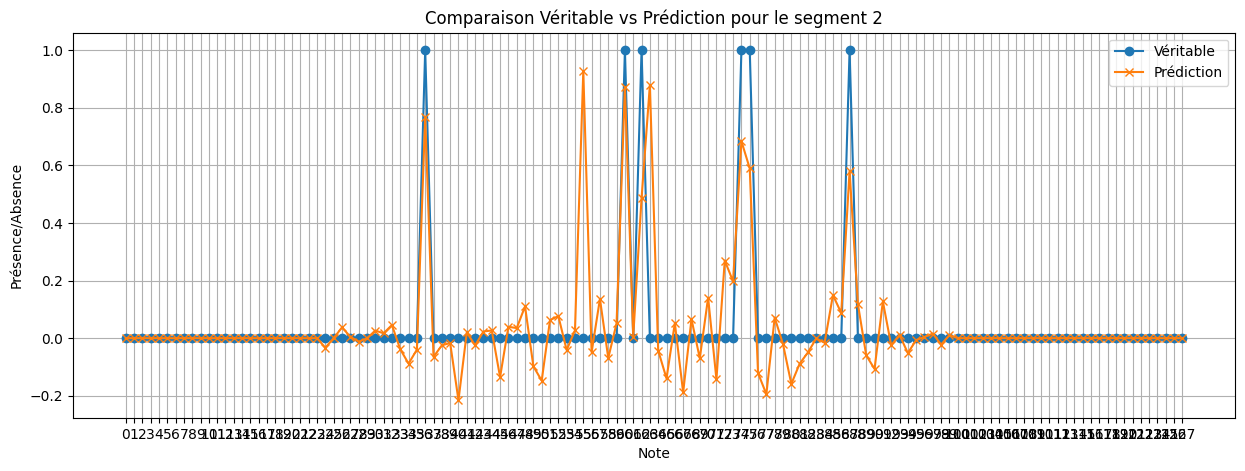

In [ ]:
import matplotlib.pyplot as plt

# Exemple de visualisation pour un seul segment
segment_index = 2  # Choisir un segment pour la visualisation

plt.figure(figsize=(15, 5))
plt.plot(Y_test[segment_index], label="Véritable", marker='o')
plt.plot(Y_pred[segment_index], label="Prédiction", marker='x')
plt.title(f"Comparaison Véritable vs Prédiction pour le segment {segment_index}")
plt.xlabel("Note")
plt.ylabel("Présence/Absence")
plt.xticks(range(len(Y_test[segment_index])))
plt.legend()
plt.grid(True)
plt.savefig('comparaison_segment.png', dpi=300)

plt.show()


# FUTUR COMPARAISON AVEC UN LSTM ?

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Configuration du modèle LSTM
model_lstm = Sequential([
    # Couche LSTM avec le même nombre d'unités que le réservoir ESN pour comparaison
    LSTM(units=500, input_shape=(None, input_dim), return_sequences=True),
    # Couche de sortie Dense, avec activation 'sigmoid' pour la prédiction binaire (présence/absence de chaque note)
    Dense(input_dim, activation='sigmoid')
])

# Compilation du modèle
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_lstm.summary()
history = model_lstm.fit(X_train, Y_train,
                         epochs=50,
                         batch_size=64,
                         validation_split=0.2,
                         verbose=1)

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model_lstm.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
